# Running Stemmus_scope emulator

This notebook shows how to:

- Preprocess data
- Run the machine learning model 
- Inspect the results by plotting

Using DAT (Deployable Analysis environmenT). It shows examples on how to use:
- Dask 
- Dask-ml
- Xarray

TODO:
- fix paths
- store data and model on zenodo


## Preparing data

In [1]:
import xarray as xr
import geopandas as gpd
from datetime import datetime, timedelta
from functools import partial
from dask.distributed import Client, LocalCluster

In [2]:
start_time = "2014-1-31"
end_time = "2014-02-10"
year = 2014

parent_in_path = f"/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/{year}global"
data_paths = {"era5land": f"{parent_in_path}/era5land/*.nc",
            "lai": f"{parent_in_path}/lai_v2/*.nc",
            "ssm": f"{parent_in_path}/ssm/GlobalGSSM11km2014_20240214.tif",
            "co2": f"{parent_in_path}/co2/CAMS_CO2_2003-2020.nc",
            "landcover": f"{parent_in_path}/igbp/landcover10km_global.nc",
            "vcmax": f"{parent_in_path}/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc",
            "canopyheight": f"{parent_in_path}/canopy_height/canopy_height_11kmEurope20230921_10km.nc",
            }

parent_out_path = "/scratch-shared/falidoost"

In [3]:
# read shape file
eu_shape_file = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/EuropeBoundary.shp"
gdf = gpd.read_file(eu_shape_file)
bbox = gdf.total_bounds
bbox

array([-31.28903052,  34.93055094,  68.93136141,  81.85192337])

In [4]:
def era5_preprocess(ds):    
    # Convert the longitude coordinates from [0, 360] to [-180, 180]
    ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
    return ds

def co2_preprocess(ds, start_time, end_time):    
    ds = ds.sel(time=slice(start_time, end_time))
    return ds

co2_partial_func = partial(co2_preprocess, start_time=start_time, end_time=end_time)

def fix_coords(ds):
    if 'band' in ds.dims:
        ds = ds.rename_dims({'band': 'time'})
        ds = ds.rename_vars({'band': 'time'})

    if 'x' in ds.dims and 'y' in ds.dims:
        ds = ds.rename_dims({'x': 'longitude', 'y': 'latitude'})
        ds = ds.rename_vars({'x': 'longitude', 'y': 'latitude'})
        
    elif 'lon' in ds.dims and 'lat' in ds.dims:
        ds = ds.rename_dims({'lon': 'longitude', 'lat': 'latitude'})
        ds = ds.rename_vars({'lon': 'longitude', 'lat': 'latitude'})
    return ds

In [5]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

In [6]:
chunks = 100

for data_path in data_paths:
    
    if data_path == "era5land":
        ds = xr.open_mfdataset(data_paths[data_path], preprocess=era5_preprocess, chunks=chunks)
    
    if data_path == "co2":
        ds = xr.open_mfdataset(data_paths[data_path], preprocess=co2_partial_func, chunks=chunks)
        ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))       

    else:
        ds = xr.open_mfdataset(data_paths[data_path], preprocess=fix_coords, chunks=chunks)
        
    # convert day of year
    if ds.time.size == 1:
        ds['time'] = [datetime.strptime(start_time, "%Y-%m-%d")]
    elif ds.time.dtype == 'int64':
        # Convert day of year to datetime
        ds['time'] = [datetime(year, 1, 1) + timedelta(int(day) - 1) for day in ds.time.values]
        
    ds_sorted = ds.sortby(['longitude', 'latitude'])
    masked_ds = ds_sorted.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]), time=slice(start_time, end_time))
    masked_ds = masked_ds.chunk(chunks=chunks)
    
    # svae to zarr
    out_path = f"{parent_out_path}/{data_path}_{start_time}_{end_time}.zarr"
    masked_ds.to_zarr(out_path, mode='w')
    print(f"{out_path} is saved")
    print("=======================================")

/scratch-shared/falidoost/era5land_2014-1-31_2014-02-10.zarr is saved


/gpfs/home4/falidoost/mamba/envs/pystemmusscope/lib/python3.10/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/gpfs/home4/falidoost/mamba/envs/pystemmusscope/lib/python3.10/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/gpfs/home4/falidoost/mamba/envs/pystemmusscope/lib/python3.10/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/gpfs/home4/falidoost/mamba/envs/pystemmusscope/lib/python3.10/site-packages/xarray/core

/scratch-shared/falidoost/lai_2014-1-31_2014-02-10.zarr is saved


/gpfs/home4/falidoost/mamba/envs/pystemmusscope/lib/python3.10/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/gpfs/home4/falidoost/mamba/envs/pystemmusscope/lib/python3.10/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


/scratch-shared/falidoost/ssm_2014-1-31_2014-02-10.zarr is saved
/scratch-shared/falidoost/co2_2014-1-31_2014-02-10.zarr is saved


/gpfs/home4/falidoost/mamba/envs/pystemmusscope/lib/python3.10/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/gpfs/home4/falidoost/mamba/envs/pystemmusscope/lib/python3.10/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


/scratch-shared/falidoost/landcover_2014-1-31_2014-02-10.zarr is saved
/scratch-shared/falidoost/vcmax_2014-1-31_2014-02-10.zarr is saved
/scratch-shared/falidoost/canopyheight_2014-1-31_2014-02-10.zarr is saved


In [7]:
client.shutdown()

## Interpolations

In [1]:
import xarray as xr
from dask.distributed import Client, LocalCluster

In [2]:
start_time = "2014-1-31"
end_time = "2014-02-10"

parent_in_path = "/scratch-shared/falidoost"
data_paths = {"era5land": f"{parent_in_path}/era5land_{start_time}_{end_time}.zarr",
              "lai": f"{parent_in_path}/lai_{start_time}_{end_time}.zarr",
              "ssm": f"{parent_in_path}/ssm_{start_time}_{end_time}.zarr",
              "co2": f"{parent_in_path}/co2_{start_time}_{end_time}.zarr",
              "landcover": f"{parent_in_path}/landcover_{start_time}_{end_time}.zarr",
              "vcmax": f"{parent_in_path}/vcmax_{start_time}_{end_time}.zarr",
              "canopyheight": f"{parent_in_path}/canopyheight_{start_time}_{end_time}.zarr",
            }
parent_out_path = "/scratch-shared/falidoost"

In [3]:
def interpolation(ds, other):
    # in time
    ds_interpolated = ds.interp(coords={"time": other["time"]}, method='nearest', kwargs={"fill_value": "extrapolate"})
    
    # in space
    ds_interpolated = ds_interpolated.interp(coords={"longitude": other["longitude"], "latitude": other["latitude"]}, method='linear')
    
    return ds_interpolated

variable_names = {"lai": "LAI",
                  "ssm": "band_data",
                  "co2": "co2",
                  "canopyheight": "__xarray_dataarray_variable__",
                  "vcmax": "__xarray_dataarray_variable__",
                  "landcover": "lccs_class"}  


era5land = xr.open_zarr(data_paths["era5land"])
other_coords = {"time": era5land.time, "longitude": era5land.longitude, "latitude": era5land.latitude}

chunks = {"time": -1, "longitude": 100, "latitude": 100}
for name in variable_names:
    ds = xr.open_zarr(data_paths[name]).chunk(chunks)
    ds_interpolated = interpolation(ds, other_coords)    
    era5land[name] = ds_interpolated[variable_names[name]]

era5land = era5land.chunk(chunks)
era5land

<xarray.Dataset>
Dimensions:       (time: 264, latitude: 469, longitude: 690)
Coordinates:
  * latitude      (latitude) float32 35.0 35.1 35.2 35.3 ... 81.5 81.6 81.7 81.8
  * longitude     (longitude) float32 0.0 0.1 0.2 0.3 ... 68.6 68.7 68.8 68.9
  * time          (time) datetime64[ns] 2014-01-31 ... 2014-02-10T23:00:00
Data variables: (12/16)
    d2m           (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
    sp            (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
    ssr           (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
    ssrd          (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
    str           (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
    strd          (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
    ...            ...
    lai           (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
    ssm           (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
    co2           (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
    canopyheight  (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
    vcmax         (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
    landcover     (time, latitude, longitude) float32 dask.array<chunksize=(264, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-19 03:39:36 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [9]:
# svae to zarr
out_path = f"{parent_out_path}/all_data_{start_time}_{end_time}.zarr"
encoding = {var: {'chunks': (era5land.sizes["time"], 100, 100)} for var in era5land.data_vars}
era5land.to_zarr(out_path, mode='w', encoding=encoding)
print(f"{out_path} is saved")

/scratch-shared/falidoost/all_data_2014-1-31_2014-02-10.zarr is saved


## Variable derivation

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
from dask.distributed import Client, LocalCluster
from PyStemmusScope import variable_conversion as vc
from dask_ml.preprocessing import OneHotEncoder

In [3]:
start_time = "2014-1-31"
end_time = "2014-02-10"

parent_in_path = "/scratch-shared/falidoost"
data_paths = {"all_data": f"{parent_in_path}/all_data_{start_time}_{end_time}.zarr",
    "igbp_table": f"{parent_in_path}/lccs_to_igbp_table.csv",
    "igbp_class": f"{parent_in_path}/IGBP11unique.csv",
            }

parent_out_path = "/scratch-shared/falidoost"

chunks = {"time": 100, "longitude": 100, "latitude": 100}

In [4]:
# era5_land variables
all_data = xr.open_zarr(data_paths["all_data"])
all_data = all_data.chunk(chunks)

In [5]:
def era5land_accumulated_vars(ds, input_name, output_name, scale_factor):    
    input_da = ds[input_name] / scale_factor
    output_da = input_da.diff("time")
    output_da[0::24] = input_da[1::24]  # accumulation starts at t01 instead of t00
    
    t00 = xr.DataArray(np.nan, coords=input_da.isel(time=0).coords) # assign first t00 to none
    output_da = xr.concat([output_da, t00], dim='time')    
    ds[output_name] = output_da
    
    return ds

### variable calculations

In [6]:
all_data = era5land_accumulated_vars(all_data, "ssrd", "Rin", 3600)
all_data = era5land_accumulated_vars(all_data, "strd", "Rli", 3600)
all_data = era5land_accumulated_vars(all_data, "tp", "Precip_msr", 0.001) # to mm
all_data["p"] = all_data["sp"] / 100  # Pa -> hPa
all_data["Ta"] = all_data["t2m"] - 273.15  # K -> degC
all_data["ea"] = vc.calculate_es(all_data["d2m"] - 273.15)*10 # *10 is for kPa -> hPa
all_data["u"] = (all_data["u10"] ** 2 + all_data["v10"] ** 2) ** 0.5
all_data["ssm"] = all_data["ssm"] / 1000

### convert landcover to IGBP

In [7]:
# lookup tables
igbp_table = pd.read_csv(data_paths["igbp_table"])
igbp_class = pd.read_csv(data_paths["igbp_class"])['0'].unique()

# define one hot encoding for IGBP using dask-ml functions
encoder = OneHotEncoder(sparse_output=False)

# Unsorted categories are not yet supported by dask-ml
igbp_stemmus_scope = np.sort(igbp_table["IGBP_STEMMUS_SCOPE"].to_numpy().reshape(-1,1))

encoder = encoder.fit(igbp_stemmus_scope)  
        
lookup_table = igbp_table.set_index("lccs_class").T.to_dict('records')[0]

def map_landcover_to_igbp(landcover_block):
    # Create a new DataArray with "no data" to hold the mapped values 
    mapped_block = da.full_like(landcover_block, fill_value="No data", dtype="U7")

    # For each key-value pair in the lookup table
    for key, value in lookup_table.items():
        # Where the landcover_block equals the current key, assign the corresponding value
        mapped_block = da.where(landcover_block == key, value, mapped_block)
    
    return mapped_block
        

def landcover_to_igbp(ds, landcover_var_name, encoder):
    landcover = ds[landcover_var_name]
    
    # Replace NaN values with "No data" or 255 in the table
    landcover = da.where(da.isnan(landcover), 255, landcover)
    
    igbp = map_landcover_to_igbp(landcover)
    igbp_reshaped = igbp.reshape(-1, 1)

    transformed = encoder.transform(igbp_reshaped)
    
    # Select the columns that correspond to the categories in igbp_class
    indices = [np.where(encoder.categories_[0] == category)[0][0] for category in igbp_class]    
    transformed = transformed[:, indices]

    # Add each column of the transformed array as a new variable in the dataset
    for i in range(transformed.shape[1]):
        ds[f"IGBP_veg_long{i+1}"] = (("time", "latitude", "longitude"), transformed[:, i].reshape(igbp.shape))

    return ds

In [8]:
ds = landcover_to_igbp(all_data, "landcover", encoder)
ds = ds.chunk(chunks)
ds

<xarray.Dataset>
Dimensions:          (latitude: 21, longitude: 51, time: 264)
Coordinates:
  * latitude         (latitude) float32 34.0 34.1 34.2 34.3 ... 35.8 35.9 36.0
  * longitude        (longitude) float32 0.0 0.1 0.2 0.3 0.4 ... 4.7 4.8 4.9 5.0
  * time             (time) datetime64[ns] 2014-01-31 ... 2014-02-10T23:00:00
Data variables: (12/34)
    canopyheight     (time, latitude, longitude) float32 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
    co2              (time, latitude, longitude) float32 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
    d2m              (time, latitude, longitude) float32 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
    lai              (time, latitude, longitude) float32 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
    landcover        (time, latitude, longitude) float32 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
    sp               (time, latitude, longitude) float32 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
    ...               ...
    IGBP_veg_long6   (time, latitude, longitude) float64 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
    IGBP_veg_long7   (time, latitude, longitude) float64 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
    IGBP_veg_long8   (time, latitude, longitude) float64 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
    IGBP_veg_long9   (time, latitude, longitude) float64 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
    IGBP_veg_long10  (time, latitude, longitude) float64 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
    IGBP_veg_long11  (time, latitude, longitude) float64 dask.array<chunksize=(100, 21, 51), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-19 03:39:36 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [9]:
# svae to zarr
out_path = f"{parent_out_path}/model_input_{start_time}_{end_time}.zarr"
encoding = {var: {'chunks': (100, 100, 100)} for var in ds.data_vars}
ds.to_zarr(out_path, mode='w', encoding=encoding)
print(f"{out_path} is saved")

/scratch-shared/falidoost/small/model_input_2014-1-31_2014-02-10.zarr is saved


## Model prediction

In [ ]:
import pickle
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
from dask.distributed import Client, LocalCluster

In [6]:
start_time = "2014-1-31"
end_time = "2014-02-10"

parent_in_path = "/scratch-shared/falidoost"
parent_in_path = "../data"
parent_out_path = "/scratch-shared/falidoost"

chunks = {"time": 100, "longitude": 100, "latitude": 100}

In [7]:
# load model
path_model = f"{parent_in_path}/hourly_multi7_depth20_min1219.pkl"
with open(path_model, 'rb') as f:
    model = pickle.load(f)
model

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=20,
                                                     min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     n_estimators=10, n_jobs=1,
                                                     random_state=0))

In [4]:
# rename some variables
model_input = xr.open_zarr(f"{parent_in_path}/model_input_{start_time}_{end_time}.zarr")
model_input = model_input.chunk(chunks)

rename_vars = {"co2": "CO2", "lai": "LAI", "canopyheight": "hc", "ssm": "SSM", "vcmax": "Vcmo"}
ds = model_input.rename(rename_vars)

input_vars = [
    'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI', 'Vcmo','hc', 'Precip_msr',  
    'SSM',  *[f'IGBP_veg_long{i}' for i in range(1, 12)]
]

# select input data 
input_ds = ds[input_vars]

# define output template
output_vars = ['LEtot','Htot','Rntot','Gtot', 'Actot','SIF685', 'SIF740']
output_temp = xr.Dataset()
ds_shape = (input_ds.sizes['time'], input_ds.sizes['latitude'], input_ds.sizes['longitude'])

for var in output_vars:
    output_temp[var] = xr.DataArray(
        name = var,
        data=da.zeros(ds_shape),
        dims=input_ds.dims,
        coords=input_ds.coords,
    )
output_temp = output_temp.chunk(chunks) # the same chunk as input

In [5]:
def predictFlux(input_ds, model, output_vars):

    df_features = input_ds.to_dataframe().reset_index().drop(columns=["time", "longitude", "latitude"])
    
    # Convert the nan value as 0 for the calculation
    df_features = df_features.fillna(0)
    
    LEH = model.predict(df_features)
    
    output_ds = xr.Dataset(coords=input_ds.coords)
    ds_shape = (output_ds.sizes['time'], output_ds.sizes['latitude'], output_ds.sizes['longitude'])
    
    for i, name in enumerate(output_vars):
        output_ds[name] = (("time", "latitude", "longitude"), LEH[:, i].reshape(ds_shape))
    
    return output_ds

In [6]:
# result
LEH = xr.map_blocks(
    predictFlux,
    input_ds,
    kwargs={
        "model": model, 
        "output_vars": output_vars, 
    },
    template=output_temp,
)
LEH = LEH.chunk(chunks)

# mask nan values
# TDOD: find nan based on all data
LEH_masked = LEH.where(input_ds["Rin"].notnull())

In [9]:
# svae to zarr
out_path = f"{parent_out_path}/predicted_{start_time}_{end_time}.zarr"
encoding = {var: {'chunks': (100, 100, 100)} for var in LEH_masked.data_vars}
LEH_masked.to_zarr(out_path, mode='w', encoding=encoding)
print(f"{out_path} is saved")

/scratch-shared/falidoost/predicted_2014-1-31_2014-02-10.zarr is saved


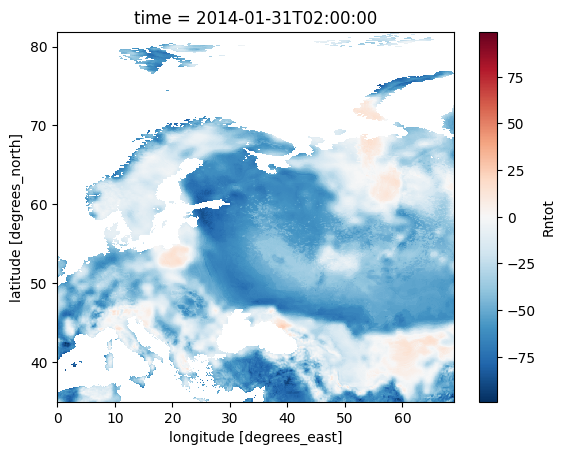

In [8]:
LEH_masked.Rntot.isel(time=2).plot()

## Model training

In [6]:
import dask.dataframe as dd
import numpy as np
import pandas as pd
from dask_ml.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from dask_ml.preprocessing import OneHotEncoder
from dask import delayed
from dask.distributed import Client, LocalCluster
from joblib import dump

/tmp/ipykernel_93282/3554534818.py:1: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use a new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

To disable this warning in the future, set dask config:

    # via Python
    >>> dask.config.set({'dataframe.query-planning-warning': False})

    # via CLI
    dask config set dataframe.query-pla

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

In [7]:
parent_in_path = "../data"
data_paths = {"input_data": f"{parent_in_path}/training/training_testing-withindex_v4_hourlyUTC.csv",
            "igbp_table": f"{parent_in_path}/lccs_to_igbp_table.csv",
            "igbp_class": f"{parent_in_path}/IGBP11unique.csv",
             }
              
input_vars = ['Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', 'IGBP_veg_long', 
              'Rntot', 'LEtot', 'Htot','Gtot', 'Actot', 'SIF685', 'SIF740']


In [8]:
input_df = dd.read_csv(data_paths["input_data"], usecols=input_vars)

#filter the outliers
input_df = input_df[(input_df['LEtot'] < 750) & (input_df['LEtot'] > -10)]
input_df = input_df[(input_df['Htot'] < 750) & (input_df['Htot'] > -500)]
input_df = input_df[input_df['Actot']>-10]

# remove nan
input_df = input_df.dropna()


In [9]:
# IGBP values
# define one hot encoding for IGBP using dask-ml functions
encoder = OneHotEncoder(sparse_output=False)

igbp_class = pd.read_csv(data_paths["igbp_class"])['0'].unique()
# Unsorted categories are not yet supported by dask-ml
igbp_stemmus_scope = np.sort(igbp_class.reshape(-1,1))
encoder = encoder.fit(igbp_stemmus_scope) 

igbp = input_df['IGBP_veg_long'].to_dask_array(lengths=True).reshape(-1, 1)
transformed = encoder.transform(igbp)

for i in range(transformed.shape[1]):
    input_df[f"IGBP_veg_long{i+1}"] = transformed[:, i]

In [10]:
input_df = input_df.drop('IGBP_veg_long', axis=1)

In [11]:
input_df.columns

Index(['Precip_msr', 'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI', 'Vcmo',
       'hc', 'Rntot', 'LEtot', 'Htot', 'Actot', 'SIF685', 'SIF740', 'Gtot',
       'SSM', 'IGBP_veg_long1', 'IGBP_veg_long2', 'IGBP_veg_long3',
       'IGBP_veg_long4', 'IGBP_veg_long5', 'IGBP_veg_long6', 'IGBP_veg_long7',
       'IGBP_veg_long8', 'IGBP_veg_long9', 'IGBP_veg_long10',
       'IGBP_veg_long11'],
      dtype='object')

In [12]:
# training

x_vars = ['Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', *[f'IGBP_veg_long{i}' for i in range(1, 12)]]
x = input_df[x_vars]

y_vars = ['LEtot','Htot','Rntot','Gtot', 'Actot','SIF685', 'SIF740']
y = input_df[y_vars]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, shuffle=True)
regressor = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=10,
                          max_depth=20,
                          random_state=0,
                          n_jobs=1,
                          min_samples_split=10,
                          min_samples_leaf=4),
    n_jobs=4,
)

regressor

In [12]:
# training 1 output

x_vars = ['Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', *[f'IGBP_veg_long{i}' for i in range(1, 12)]]
x = input_df[x_vars]

y_vars = ['LEtot']
y = input_df[y_vars]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, shuffle=True)
regressor = RandomForestRegressor(n_estimators=10,
                          max_depth=20,
                          random_state=0,
                          n_jobs=1,
                          min_samples_split=10,
                          min_samples_leaf=4)

regressor

RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=10, n_jobs=1, random_state=0)

In [14]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

In [15]:
x_train_computed = x_train.compute()
y_train_computed = y_train.compute()

In [ ]:
client.shutdown()

In [16]:
regressor.fit(x_train_computed, y_train_computed)
dump(regressor, f"{parent_in_path}/model_{y_vars[0]}.joblib")
print("model is saved")

/tmp/ipykernel_65798/1878836558.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x_train_computed, y_train_computed)


model is saved
